**Importacion de las librerias**


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime

Funcion generadora de ruido gassiano utilizando le metodo de Box-Muller Transformation

In [ ]:
def obtener_segundos_actual():
    # Obtener la hora actual
    hora_actual = datetime.datetime.now()
    
    # Extraer los segundos de la hora actual
    segundos = hora_actual.second
    
    return segundos

In [ ]:
def obtener_minutos_actual():
    # Obtener la hora actual
    hora_actual = datetime.datetime.now()
    
    # Extraer los minutos de la hora actual
    minutos = hora_actual.minute
    
    return minutos

In [ ]:
def obtener_hora_actual():
    # Obtener la hora actual
    hora_actual = datetime.datetime.now()
    
    # Extraer solo la hora actual
    hora = hora_actual.hour
    
    return hora


In [ ]:


PI = 3.1415926536

def AWGN_generator():
    
    """Genera muestras de ruido gaussiano blanco con media cero y desviación estándar de uno."""
    temp2 = np.random.rand()
    temp1 = np.cos(2.0 * PI * np.random.rand())
    result = math.sqrt(-2.0 * math.log(temp2)) * temp1

    # Escala el resultado al rango [-1, 1]
    result = np.clip(result, -1, 1)
    
    return result


In [ ]:
# funcion aleatorizadora de semilla
def random_semilla ():
    np.random.seed(int(obtener_segundos_actual()*obtener_minutos_actual()*obtener_hora_actual()))
    

In [ ]:
def agregar_ruido(datos):
    for indice_fila, fila in datos.iterrows():
        for indice_elemento, elemento in enumerate(fila):
            parte_real, parte_imaginaria = np.real(elemento), np.imag(elemento)
            ruido_real, ruido_imaginario = AWGN_generator(), AWGN_generator()
            datos.iloc[indice_fila, indice_elemento] = parte_real + ruido_real + 1j * (parte_imaginaria + ruido_imaginario)
    return datos

In [ ]:
def lector_csv():
  
    import pandas as pd

    # Nombre del archivo CSV
    archivo_csv = 'modulado.txt'
    
    # Cargar el archivo CSV en un DataFrame de Pandas
    datos = pd.read_csv(archivo_csv, header=None)
    
    # Cambiar la letra 'i' por 'j' en cada dato y convertirlos en números complejos
    datos[0] = datos[0].str.replace('i', 'j')
    datos[0] = datos[0].apply(lambda x: complex(x))
    
    # Mostrar el DataFrame resultante
    return datos
    
   

In [ ]:
def simular_multipath(datos, num_caminos=3, retraso_max=5):
    datos_multipath = datos.copy()
    num_filas = datos.shape[0]
    
    for indice_fila, fila in datos.iterrows():
        multipath_signal = np.zeros_like(fila, dtype=complex)
        for _ in range(num_caminos):
            retraso = np.random.randint(0, retraso_max)
            ganancia = np.random.uniform(0.5, 1.0)
            multipath_signal += np.roll(fila, retraso) * ganancia
        datos_multipath.iloc[indice_fila] = multipath_signal
    
    return datos_multipath

In [189]:
def graficar_real(datos, titulo):
    # Toma solo las primeras 250 muestras del DataFrame
    datos = datos.head(250)
    
    magnitudes = np.abs(datos[0])  # Calcula las magnitudes de los números complejos
    fases = np.angle(datos[0])  # Calcula las fases de los números complejos
    cosenos_fase = np.cos(fases)  # Calcula el coseno de las fases
    
    # Multiplica la magnitud por el coseno de la fase
    magnitud_por_cos_fase = magnitudes * cosenos_fase
    
    # Grafica la magnitud por el coseno de la fase
    plt.plot(magnitud_por_cos_fase)
    plt.title(titulo)
    plt.xlabel('Tiempo')
    plt.ylabel('Magnitud')
    plt.show()

In [ ]:
def graficar_multipath_real(datos, datos_multipath):
    plt.figure(figsize=(10, 6))
    plt.plot(np.real(datos[0]), label='Original (Parte Real)', color='blue')
    plt.plot(np.real(datos_multipath[0]), label='Multipath (Parte Real)', color='red')
    plt.title('Señal con Efecto Multipath (Parte Real)')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.legend()
    plt.grid(True)
    plt.show()

In [187]:
def calcular_capacidad_canal(B, SNR):
    C = B * np.log2(1 + SNR)
    return C

In [ ]:
def analizar_saturacion(C, velocidad_transferencia):
    if velocidad_transferencia > C:
        print(f"El canal se puede saturar. Capacidad del canal: {C:.2f} bps, Velocidad de transferencia: {velocidad_transferencia:.2f} bps")
    else:
        print(f"El canal no se saturará. Capacidad del canal: {C:.2f} bps, Velocidad de transferencia: {velocidad_transferencia:.2f} bps")

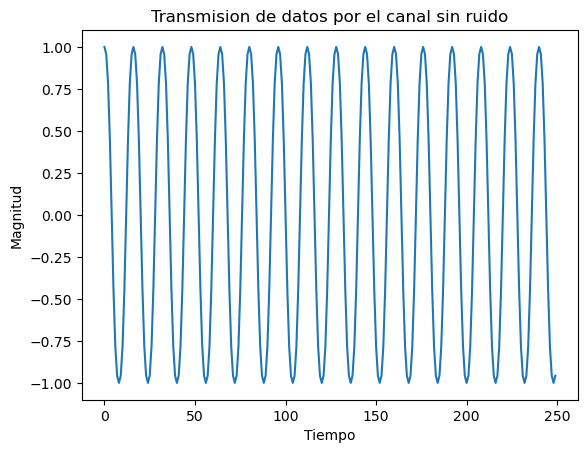

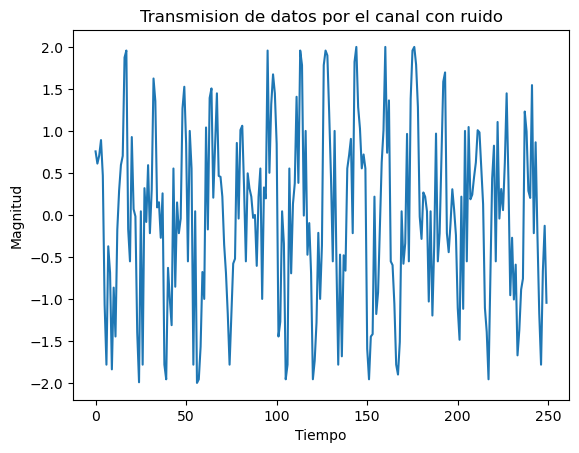

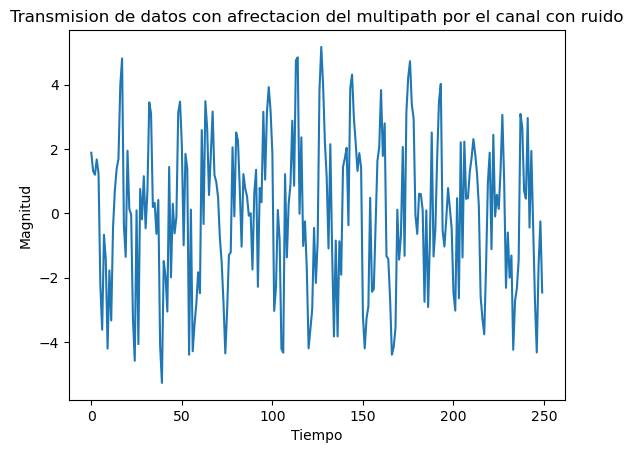

Los datos con ruido se han guardado en el archivo 'salida_canal.txt'.
Capacidad del canal: 6918863.24 bps
El canal no se saturará. Capacidad del canal: 6918863.24 bps, Velocidad de transferencia: 1000000.00 bps


In [194]:
# Llamar a las funciones
data_frame = lector_csv()
# Grafica datos sin ruido
graficar_real(data_frame, "Transmision de datos por el canal sin ruido")
# Grafica datos con ruido
datos_con_ruido = agregar_ruido(data_frame)
# Grafica datos con ruido
graficar_real(datos_con_ruido, "Transmision de datos por el canal con ruido")
#Agrega multiplth
datos_multipath = simular_multipath(data_frame)
# Grafica datos con multipath
graficar_real(datos_multipath,"Transmision de datos con afrectacion del multipath por el canal con ruido") # Se puede apreciar el efecto de estas con la magnitud que es la suma de varias senales con diferente dealay
datos_con_ruido[0] = datos_con_ruido[0].apply(lambda x: str(x))
datos_con_ruido[0] = datos_con_ruido[0].str.replace('j', 'i')
datos_con_ruido.to_csv('salida_canal.txt', index=False, header=None)

print("Los datos con ruido se han guardado en el archivo 'salida_canal.txt'.")

# Parámetros para el cálculo de capacidad
B = 2e6  # Ancho de banda en Hz (por ejemplo, 2 MHz)
SNR = 10  # Relación señal-ruido

# Calcular capacidad del canal
capacidad_canal = calcular_capacidad_canal(B, SNR)
print(f"Capacidad del canal: {capacidad_canal:.2f} bps")

# Velocidad de transferencia del nRF52832
velocidad_transferencia = 1e6  # 1 Mbps

# Analizar saturación del canal
analizar_saturacion(capacidad_canal, velocidad_transferencia)


